In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import timeit
import scipy.fftpack
import scipy.io as sio
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import interpolate
from PIL import Image


---
# VIDEO: Rhythmicity in walking (gait)
---


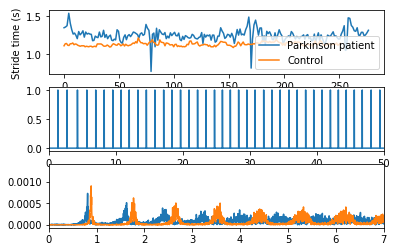

In [41]:
# Load the data. If you get an error on this line,
# make sure your Python session is in the same directory as the data.
matdata = sio.loadmat('gait.mat')

# extract data from mat file
park = matdata['park']
cont = matdata['cont']

# plot the gait speed for Parkinson's patient and control
plt.subplot2grid((3,1),(0,0))
plt.plot(park[:,0],park[:,1],label='Parkinson patient')
plt.plot(cont[:,0],cont[:,1],label='Control')
plt.xlabel('Time (sec.)')
plt.ylabel('Stride time (s)')
plt.legend()


#% define sampling rate
srate  = 1000

# create time series of steps
parkts = np.zeros(int(park[-1,0]*1000))
for i in range(0,len(park)):
    parkts[int(park[i,0]*1000-1)] = 1

# time vector and number of time points
parktx = np.arange(0,len(parkts))/srate
parkn  = len(parktx)


# repeat for control data
contts = np.zeros(int(cont[-1,0]*1000))
for i in range(0,len(cont)):
    contts[int(cont[i,0]*1000-1)] = 1

# time vector and number of time points
conttx = np.arange(0,len(contts))/srate
contn  = len(conttx)



# plot the time course of steps
plt.subplot2grid((3,1),(1,0))
plt.plot(parktx,parkts) # should be a stemplot, but that's really slow to render
plt.xlim([0,50])


# compute power for both datasets
parkPow = 2*np.abs(scipy.fftpack.fft(parkts)/parkn)
contPow = 2*np.abs(scipy.fftpack.fft(contts)/contn)

# compute separate frequencies vector for each subject
parkHz = np.linspace(0,srate/2,int(np.floor(parkn/2)+1))
contHz = np.linspace(0,srate/2,int(np.floor(contn/2)+1))

# show power spectra
plt.subplot2grid((3,1),(2,0))
plt.plot(parkHz[1:],parkPow[1:len(parkHz)])
plt.plot(contHz[1:],contPow[1:len(contHz)])
plt.xlim([0,7])

plt.show()

# SOURCES:
#  Data downloaded from https://physionet.org/physiobank/database/gaitdb/
#   Parkinson's patient data is pd1-si.txt
#   Young control data is y1-23.si.txt


---
# VIDEO: Rhythmicity in brain waves
---


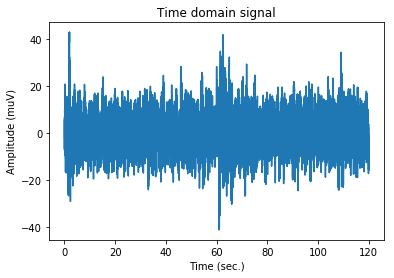

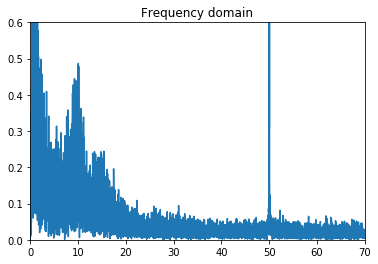

In [119]:

matdata = sio.loadmat('EEGrestingState.mat')

# extract data from mat file
eegdata = matdata['eegdata']
eegdata = eegdata[0]
srate   = matdata['srate']
srate   = srate[0]


n = len(eegdata)
timevec = np.arange(n)/srate

# compute amplitude spectrum
dataX    = scipy.fftpack.fft(eegdata)/n
ampspect = 2*abs(dataX)
hz       = np.linspace(0,srate/2,int(np.floor(n/2)+1))

plt.plot(timevec,eegdata)
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude (muV)')
plt.title('Time domain signal')
plt.show()

# show amplitude spectrum
plt.plot(hz,ampspect[0:int(np.floor(n/2)+1)])
plt.xlim([0,70])
plt.ylim([0,.6])
plt.title('Frequency domain')
plt.show()


---
# VIDEO: Convolution theorem
---


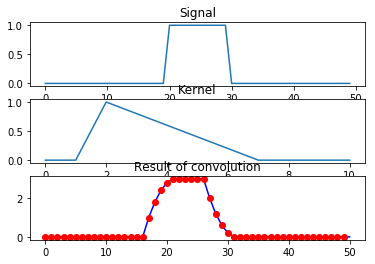

In [137]:

m = 50 # length of signal
n = 11 # length of kernel

signal = np.zeros(m)
signal[range(int(m*.4),int(m*.6))] = 1


kernel = np.zeros(n)
kernel[range(int(n*.25),int(n*.8))] = np.linspace(1,0,int(n*.55))


# plot signal
plt.subplot2grid((3,1),(0,0))
plt.plot(signal)
plt.title('Signal')

# plot kernel
plt.subplot2grid((3,1),(1,0))
plt.plot(kernel)
plt.title('Kernel')


# setup convolution parameters
nConv = m+n-1
halfk = np.floor(n/2)

# convolution as point-wise multiplication of spectra and inverse
mx = scipy.fftpack.fft(signal,nConv)
nx = scipy.fftpack.fft(kernel,nConv)
# here's the convolution:
convres = np.real( scipy.fftpack.ifft( np.multiply(mx,nx) ) )
# chop off the 'wings' of convolution
convres = convres[range(int(halfk),int(len(convres)-halfk+1))]


# plot the result of convolution
plt.subplot2grid((3,1),(2,0))
plt.plot(convres,'b')
plt.title('Result of convolution')

# for comparison, plot against the Python convolution function
plt.plot(np.convolve(signal,kernel,mode='same'),'ro')

plt.show()


---
# VIDEO: Narrowband temporal filtering
---


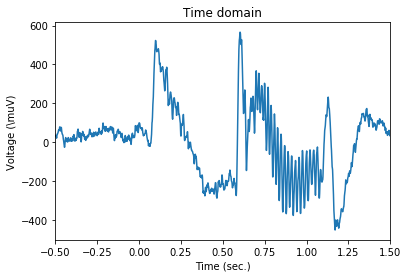

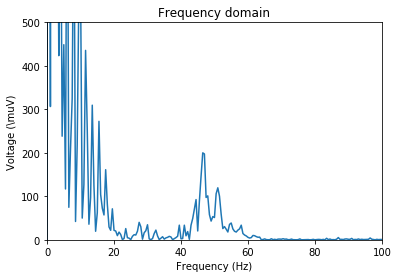

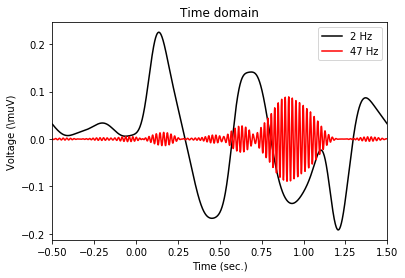

In [142]:

matdata = sio.loadmat('braindata.mat')

# extract data from mat file
timevec = matdata['timevec']
timevec = timevec[0]
srate    = matdata['srate']
srate    = srate[0]
braindata = matdata['braindata']
braindata = braindata[0]


n = len(timevec)

# plot time-domain signal
plt.plot(timevec,braindata)
plt.xlim([-.5,1.5])
plt.xlabel('Time (sec.)')
plt.ylabel('Voltage (\muV)')
plt.title('Time domain')
plt.show()


# compute power spectrum
dataX    = scipy.fftpack.fft(braindata)/n
ampspect = 2*np.abs(dataX)**2
hz       = np.linspace(0,srate,n) # out to srate as trick for the filter

# plot power spectrum
plt.plot(hz,ampspect[0:len(hz)])
plt.xlim([0,100])
plt.ylim([0,500])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Voltage (\muV)')
plt.title('Frequency domain')
plt.show()


# specify which frequencies to filter
peakFiltFreqs = [2,47] # Hz

c = 'kr' # line colors

# loop over frequencies
for fi in range(0,len(peakFiltFreqs)):
    
    # construct the filter
    x  = hz-peakFiltFreqs[fi] # shifted frequencies
    fx = np.exp(-(x/4)**2)    # gaussian
    
    # apply the filter to the data
    filtdat = 2*np.real( scipy.fftpack.ifft( np.multiply(dataX,fx) ))
    
    # show the results
    plt.plot(timevec,filtdat,c[fi],label='%g Hz' %peakFiltFreqs[fi])
    plt.xlim([-.5,1.5])
    plt.xlabel('Time (sec.)')
    plt.ylabel('Voltage (\muV)')
    plt.title('Time domain')

plt.legend()
plt.show()


---
# VIDEO: Image smoothing and sharpening
---


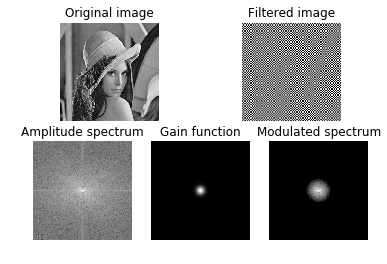

In [207]:
# load image and convert to float
lenna = np.asarray( Image.open("Lenna.png") )
imgL  = np.mean(lenna,axis=2)

# plot original image
plt.subplot2grid((2,2),(0,0))
plt.imshow(imgL,cmap=plt.cm.gray)
plt.axis('off')
plt.title('Original image')


# and its power spectrum
imgX  = scipy.fftpack.fftshift(scipy.fftpack.fft2(imgL))
powr2 = np.log(np.abs(imgX))

plt.subplot2grid((2,3),(1,0))
plt.imshow(powr2,cmap=plt.cm.gray)
plt.clim([0,15])
plt.axis('off')
plt.title('Amplitude spectrum')


# filter kernel is a Gaussian
width = .1 # width of gaussian (normalized Z units)
lims  = np.shape(imgL)
xr    = stats.zscore(np.arange(lims[0]))
[x,y] = np.meshgrid(xr,xr)

# add 1- at beginning of the next line to invert the filter
gaus2d = np.exp( -( x**2 + y**2 ) / (2*width**2) )


# show Gaussian
plt.subplot2grid((2,3),(1,1))
plt.imshow(gaus2d,cmap=plt.cm.gray)
plt.axis('off')
plt.title('Gain function')


# show modulated spectrum
plt.subplot2grid((2,3),(1,2))
plt.imshow( np.log(np.abs( np.multiply(imgX,gaus2d)) ) ,cmap=plt.cm.gray)
plt.axis('off')
plt.clim([0,15])
plt.title('Modulated spectrum')


# and the reconstructed image
imgrecon = np.real(scipy.fftpack.ifft2( np.multiply(imgX,gaus2d) ))

plt.subplot2grid((2,2),(0,1))
plt.imshow( imgrecon ,cmap=plt.cm.gray)
plt.axis('off')
plt.title('Filtered image')

plt.show()


---
# VIDEO: Image narrowband filtering
---


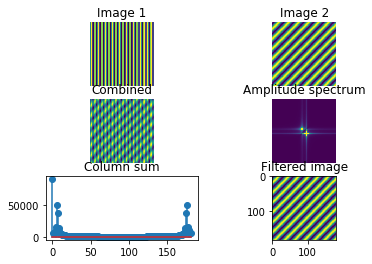

In [3]:

# specify vector of sine phases
sinephas = [ 0 , np.pi/4 ]

# vector of sine frequencies
sinefreq = [.1 , .05] # arbitrary units


# sine wave initializations
lims  = [-91,91]
[x,y] = np.meshgrid(range(lims[0],lims[1]),range(lims[0],lims[1]))


# compute 2D sine gradients
xp = x*np.cos(sinephas[0]) + y*np.sin(sinephas[0])
img1 = np.sin( 2*np.pi*sinefreq[0]*xp )

xp = x*np.cos(sinephas[1]) + y*np.sin(sinephas[1])
img2 = np.sin( 2*np.pi*sinefreq[1]*xp )

# combine images
img = img1+img2



# show original two gradients
plt.subplot2grid((3,2),(0,0))
plt.imshow(img1)
plt.axis('off')
plt.title('Image 1')

plt.subplot2grid((3,2),(0,1))
plt.imshow(img2)
plt.axis('off')
plt.title('Image 2')


# show sum
plt.subplot2grid((3,2),(1,0))
plt.imshow(img)
plt.axis('off')
plt.title('Combined')


# FFT
imgX    = scipy.fftpack.fft2(img)
imgXamp = np.abs(imgX)

# show amplitude spectrum
plt.subplot2grid((3,2),(1,1))
plt.imshow(scipy.fftpack.fftshift(imgXamp))
plt.axis('off')
plt.clim([0,500])
plt.title('Amplitude spectrum')

# show sum down columns
plt.subplot2grid((3,2),(2,0))
plt.stem(np.sum(imgXamp,axis=1))
plt.title('Column sum')

# replace 1st column with last
imgX[0,:] = imgX[-1,:]

# reconstructed image
imgrecon  = np.real( scipy.fftpack.ifft2(imgX) )

plt.subplot2grid((3,2),(2,1))
plt.imshow(imgrecon)
plt.title('Filtered image')

plt.show()